In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter

from mockobservation_tools.galaxy_tools import (load_halo,
                                                load_sim,
                                                mask_sim_to_halo,
                                                get_mock_observation,
                                                convert_kpc_to_arcsec)

from mockobservation_tools.general_tools import (measure_surfbright, 
                                                 mag_to_lum_SB)

from mockobservation_tools.sersic_tools import fit_sersic


from firestudio.utils.stellar_utils import raytrace_projection

%matplotlib inline


Missing firefly, obtain it at http://github.com/ageller/Firefly or pip install firefly.


### Note:
This notebook was set up to run on GreenPlanet based on the paths used.

### Resolution of Images

The output of get_mock_observation uses a smoothing length of a minimium of the pixel size, and uses the h$_{sml}$ from the simulation.

Then to recreate a telescope resolution, I put the band array through a gaussian_filter to smooth the image. 

gaussian_filter uses sigma is the number of pixels. https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter.html


###### List of Simulations

These have 184, host filetype='ascii'
'm10b_res500', 'm10c_res500', 'm10d_res500', 'm10e_res500', 'm10f_res500', 'm10g_res500','m10h_res500',
'm10i_res500', 'm10j_res500','m10k_res500','m10l_res500','m10m_res500','m10q_res250'

These have 152, host filetype='hdf5'
'm10xc_res4000'

These have 600, host filetype='hdf5' (don't use the ascii)
'm11a_res2100','m11b_res2100','m11c_res2100', 'm11d_res7100', 'm11e_res7100',
'm11h_res7100','m11i_res7100','m11q_res7100','m11v_res7100'


In [2]:
sim = 'm11c_res2100'

snap_num = 600

# path to the directory holding the simulation snapshot 
sim_path =  '/DFS-L/DATA/cosmo/grenache/aalazar/FIRE/GVB/'+str(sim)+'/output/hdf5/snapdir_'+str(snap_num)+'/'

# path to the directory holding the halo files for the simulation
halo_path = '/DFS-L/DATA/cosmo/grenache/aalazar/FIRE/GVB/'+str(sim)+'/halo/rockstar_dm/hdf5/'


In [3]:
# This loads the halo file
# host=True means it only returns the host halo information, otherwise it returns all the halos
# filetype='hdf5' indicate the halo file type, some halos are filetype='ascii'
# hostnumber indicates which host halo you are looking at. Only need to worry about this for the elvis pairs.
        #use hostnumber=2 to get the halo info for the second host halo. 
        #ex: halo_themla = load_halo(halo_path, snap_num, host=True, filetype='hdf5', hostnumber=1)
        #    halo_louise = load_halo(halo_path, snap_num, host=True, filetype='hdf5', hostnumber=2)


halo = load_halo(halo_path, snap_num, host=True, filetype='hdf5', hostnumber=1)


In [4]:
# This loads the star and gas particle
# It only loads the parameters I need for the mock images

star_snapdict, gas_snapdict = load_sim(sim_path,snap_num)


In [5]:
# This centers star and gas dictionaries on the host halo
# If orient=True, then it will rotate the particles based on the disk orientation
# If lim=True, then it masks out the particles beyond the limvalue
    # Have lim=False if you want to carry around all the particles
    # I chose to mask out particles beyond the virial radius

limvalue = halo['rvir'].values[0] * 0.05

star_snapdict, gas_snapdict, halo = mask_sim_to_halo(star_snapdict=star_snapdict,
                                                         gas_snapdict=gas_snapdict, 
                                                         host_halo=halo, 
                                                         orient=True,
                                                         lim = True,
                                                         limvalue = limvalue
                                                        )


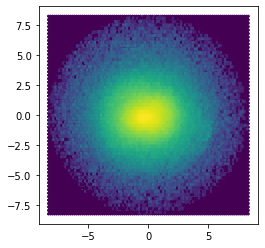

In [6]:
plt.hexbin(star_snapdict['Coordinates'][:,0],star_snapdict['Coordinates'][:,1], bins='log')
plt.gca().set_aspect(1)

In [7]:
mass_scaler = 1e-10
bands = [1,2,3]

#Field of view for the image in kpc
FOV = limvalue 
#Number 0f pixels
pixels = 500
# the axis it is projected on, 'xy', 'yz', 'zx'
view = 'xy' 
# use the center of mass or center of light, 'light', 'mass'
center = 'light'
# the limiting surface brightness, if you dont want to limit it set it equal to zero
#minden = gen.mag_to_lum_SB(29,None) # I set it to 29 mag/arcsec^2. This function convers it to lum/kpc^2
minden = mag_to_lum_SB(29,None)
image,out_band0,out_band1,out_band2 = get_mock_observation(star_snapdict,
                                                               gas_snapdict,
                                                               bands = bands,
                                                               FOV=FOV,
                                                               mass_scaler = mass_scaler,
                                                               pixels=pixels,
                                                               view=view,
                                                               minden = minden,
                                                               center = center
                                                              )

Calculating L/M in Sloan u (BAND_ID=1,l=3551 A)
Calculating L/M in Sloan g (BAND_ID=2,l=4686 A)
Calculating L/M in Sloan r (BAND_ID=3,l=6165 A)
Projecting with attenuation...
total lum before attenuation in each band (Lsun/1e10): [0.14914252 0.09071667 0.06498551]
opacity in each band: [1585.97915621 1154.44253194  799.38644653]
total gas mass: 0.023014547818979224
maxden ==  83401687.7196553  dynrange ==  912.7983347788378  minden ==  91369.23736814522


/export/nfs0home/kleinca/fire_tools/FIRE_studio/firestudio/utils/stellar_utils/make_threeband_image.py:129: RuntimeWarning: divide by zero encountered in log10
  f_i = np.log10(i/minnorm) / np.log10(maxnorm/minnorm);
/export/nfs0home/kleinca/fire_tools/FIRE_studio/firestudio/utils/stellar_utils/make_threeband_image.py:137: RuntimeWarning: divide by zero encountered in log
  r = np.log(r/minnorm) / np.log(maxnorm/minnorm);
/export/nfs0home/kleinca/fire_tools/FIRE_studio/firestudio/utils/stellar_utils/make_threeband_image.py:138: RuntimeWarning: divide by zero encountered in log
  g = np.log(g/minnorm) / np.log(maxnorm/minnorm);
/export/nfs0home/kleinca/fire_tools/FIRE_studio/firestudio/utils/stellar_utils/make_threeband_image.py:139: RuntimeWarning: divide by zero encountered in log
  b = np.log(b/minnorm) / np.log(maxnorm/minnorm);


In [8]:
#Sersic fit with the Mock Images

z = 0.005

size_per_pixel = 2 * FOV / pixels

arc_per_pixel = convert_kpc_to_arcsec(size_per_pixel,z)

telescope_resolution = 2 #arcsec

n_pixel_resolution = telescope_resolution / arc_per_pixel



print(f'Redshift:               {z:.3f}')
      
print(f'Pixel size [kpc]:       {size_per_pixel:.3f}')

print(f'Pixel size [arcsec]:    {arc_per_pixel:.3f}')

print(f'Telescope Res [arcsec]: {telescope_resolution:.3f}')

print(f'N pixels for Res:       {n_pixel_resolution:.3f}')


Redshift:               0.005
Pixel size [kpc]:       0.033
Pixel size [arcsec]:    0.314
Telescope Res [arcsec]: 2.000
N pixels for Res:       6.367


In [9]:
FOV_arc = convert_kpc_to_arcsec(FOV,z)
        # Pixel size is 0.4 arcsec 
        # seeing is 2 acrsec
n_measure = int(FOV_arc/ 0.8) # spaced 2 pixels

print(f'FOV [kpc]:       {FOV:.3f}')
print(f'FOV [arcsec]:    {FOV_arc:.3f}')

FOV [kpc]:       8.369
FOV [arcsec]:    78.527


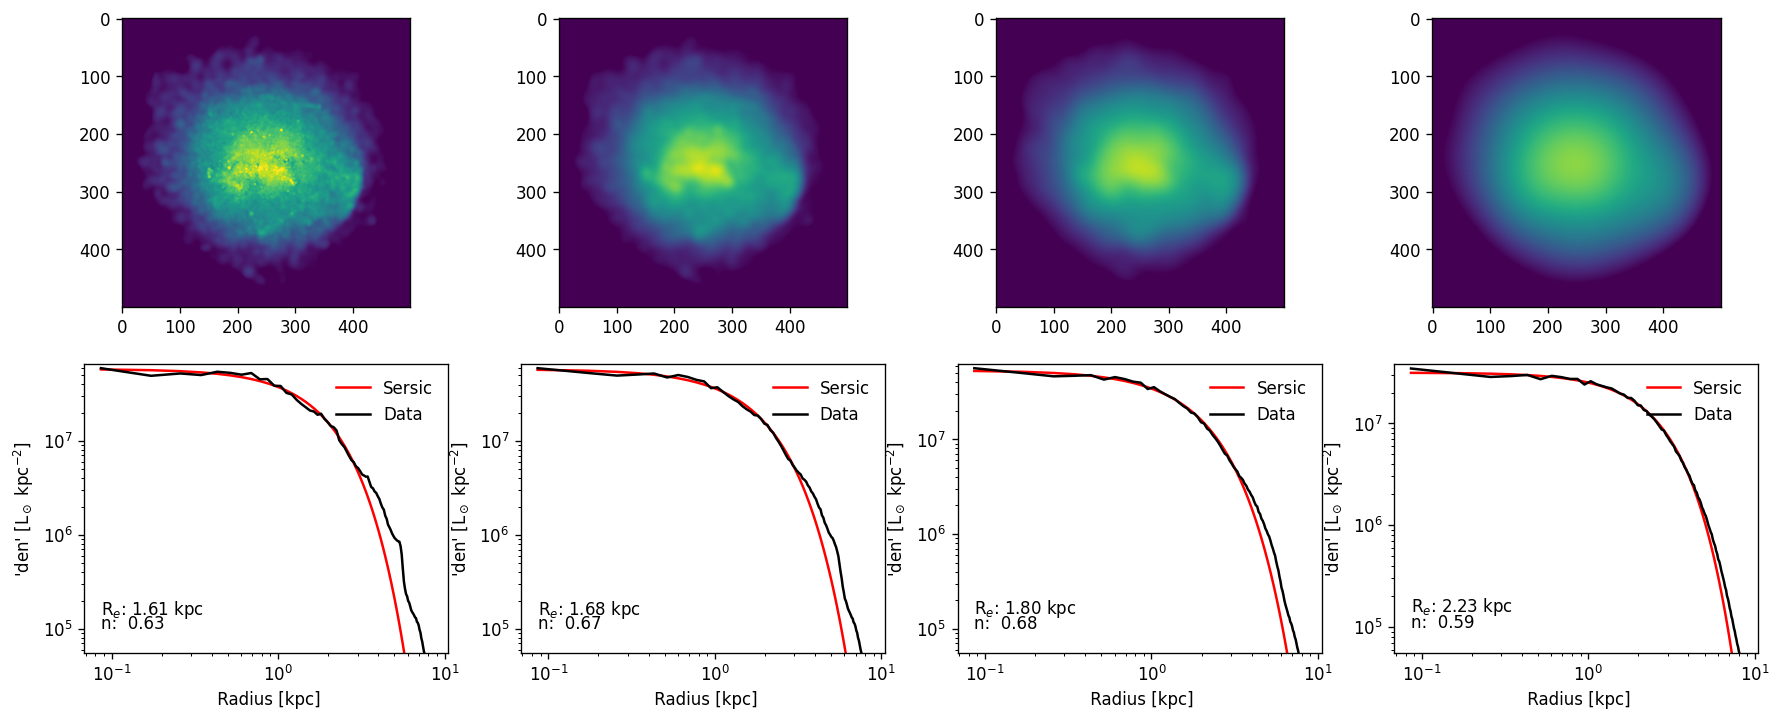

In [10]:
fig, axs = plt.subplots(2,4,figsize=(18, 7))

axs[0,0].imshow(np.log10(out_band1+1),vmin=5, vmax=8)
radius,sb = measure_surfbright(out_band1, FOV=FOV, nmeasure=n_measure, sb_lim=0)
fit_sersic(radius, sb, ax_sersic=axs[1,0])


axs[0,1].imshow(np.log10(gaussian_filter(out_band1+1,sigma=n_pixel_resolution)),vmin=5, vmax=8)
radius1,sb1 = measure_surfbright(gaussian_filter(out_band1,sigma=n_pixel_resolution), 
                                   FOV=FOV, nmeasure=n_measure, sb_lim=0)
fit_sersic(radius1, sb1, ax_sersic=axs[1,1])


axs[0,2].imshow(np.log10(gaussian_filter(out_band1+1,sigma=n_pixel_resolution*2)),vmin=5, vmax=8)
radius2,sb2 = measure_surfbright(gaussian_filter(out_band1,sigma=n_pixel_resolution*2), 
                                   FOV=FOV, nmeasure=n_measure,sb_lim=0)
fit_sersic(radius2, sb2, ax_sersic=axs[1,2])


axs[0,3].imshow(np.log10(gaussian_filter(out_band1+1,sigma=n_pixel_resolution*5)),vmin=5, vmax=8)
radius3,sb3 = measure_surfbright(gaussian_filter(out_band1,sigma=n_pixel_resolution*5), 
                                   FOV=FOV, nmeasure=n_measure,sb_lim=0)
fit_sersic(radius3, sb3, ax_sersic=axs[1,3])

plt.show()